In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import shap 
import matplotlib.pyplot as plt
import seaborn as sns

shap.initjs()

In [3]:
#Loading Model, Scaler, and Hybrid Dataset
model_path = r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\models\xgboost_hybrid_model.json"
scaler_path = r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\models\xgboost_hybrid_scaler.pkl"
data_path = r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\data\MachineLearningCSV\MachineLearningCVE\CICIDS2017_hybrid_ready.csv"

#load saved model
xgb_hybrid = xgb.XGBClassifier()
xgb_hybrid.load_model(model_path)

#load saved scaler
scaler_hybrid = joblib.load(scaler_path)

#Load hybrid dataset
df = pd.read_csv(data_path)
X = df.drop(columns=["Label"])
y = df["Label"]

#Scale
X_scaled = scaler_hybrid.transform(X)

print("Model, Scaler, and Data Loaded Successfully")
print("Feature shape:", X_scaled.shape)

Model, Scaler, and Data Loaded Successfully
Feature shape: (2604998, 79)


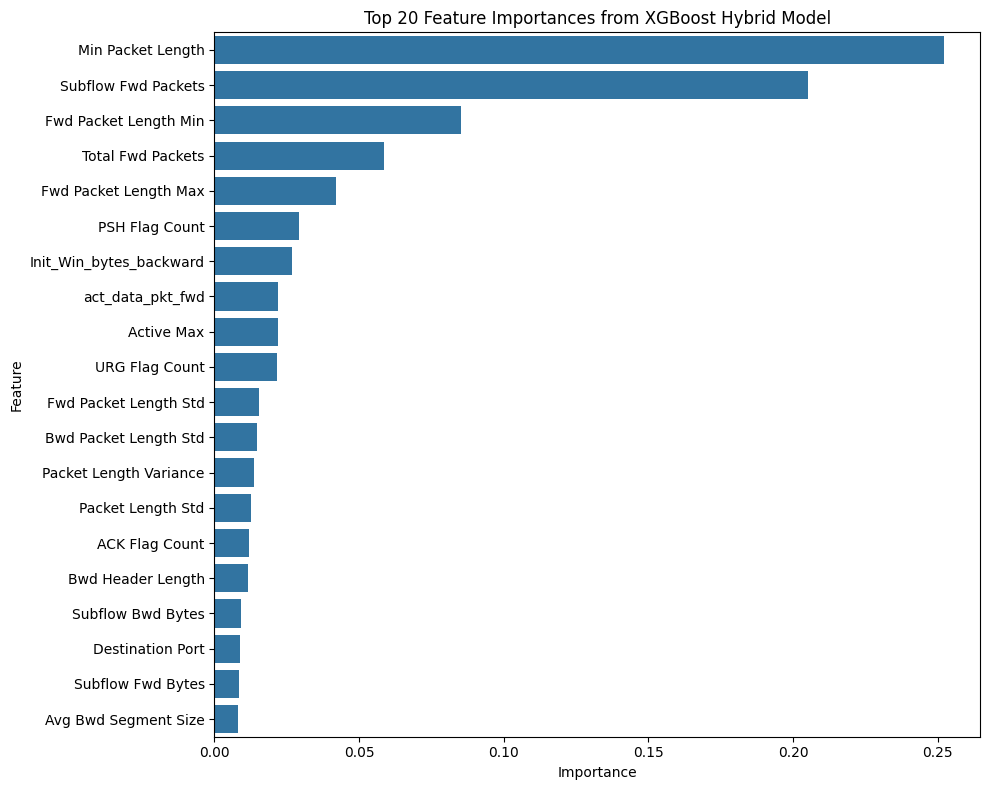

,Feature,Importance
38,Min Packet Length,0.251964
62,Subflow Fwd Packets,0.205240
7,Fwd Packet Length Min,0.085279
2,Total Fwd Packets,0.058597
6,Fwd Packet Length Max,0.042149
46,PSH Flag Count,0.029132
67,Init_Win_bytes_backward,0.026662
68,act_data_pkt_fwd,0.022072
72,Active Max,0.021984
48,URG Flag Count,0.021626


In [5]:
#Feature Importance 
importances = xgb_hybrid.feature_importances_
feature_names = X.columns

fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(data=fi_df.head(20), x='Importance', y='Feature')
plt.title('Top 20 Feature Importances from XGBoost Hybrid Model')
plt.tight_layout()
plt.show()

fi_df.head(20)

In [6]:
#SHAP Global Explanation
explainer = shap.TreeExplainer(xgb_hybrid)
shap_values = explainer.shap_values(X_scaled)

print("SHAP values computed.")

SHAP values computed.


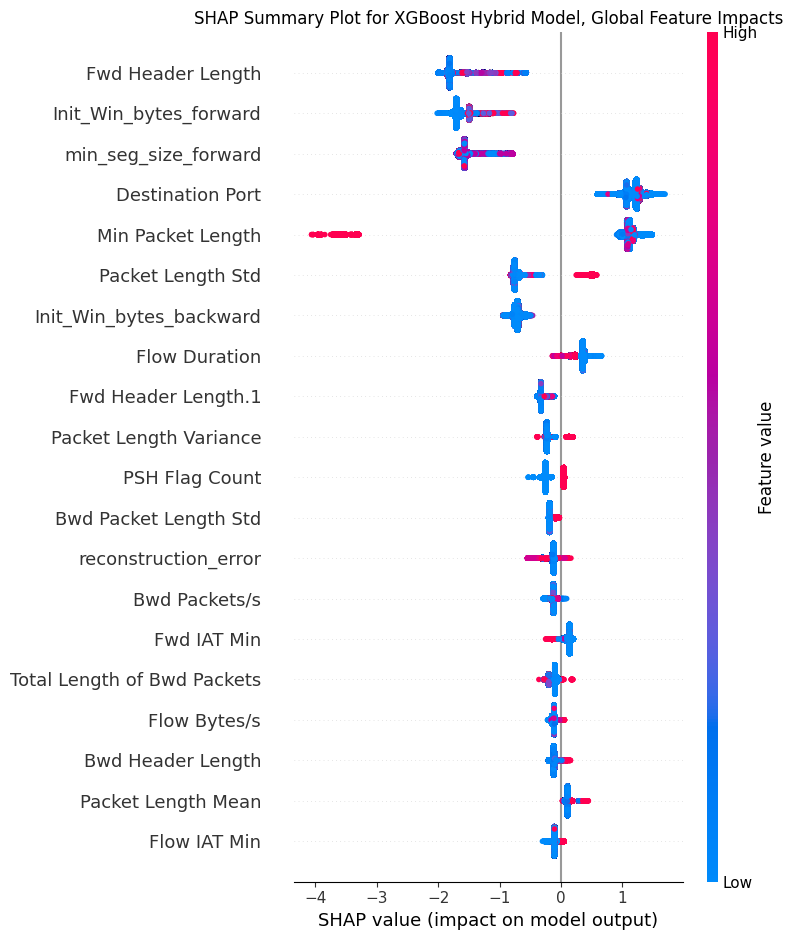

In [ ]:
plt.figure(figsize=(16,6))
shap.summary_plot(shap_values, X, plot_type="dot", show=False)
plt.title('SHAP Summary Plot for XGBoost Hybrid Model, Global Feature Impacts')
plt.tight_layout()
plt.show()

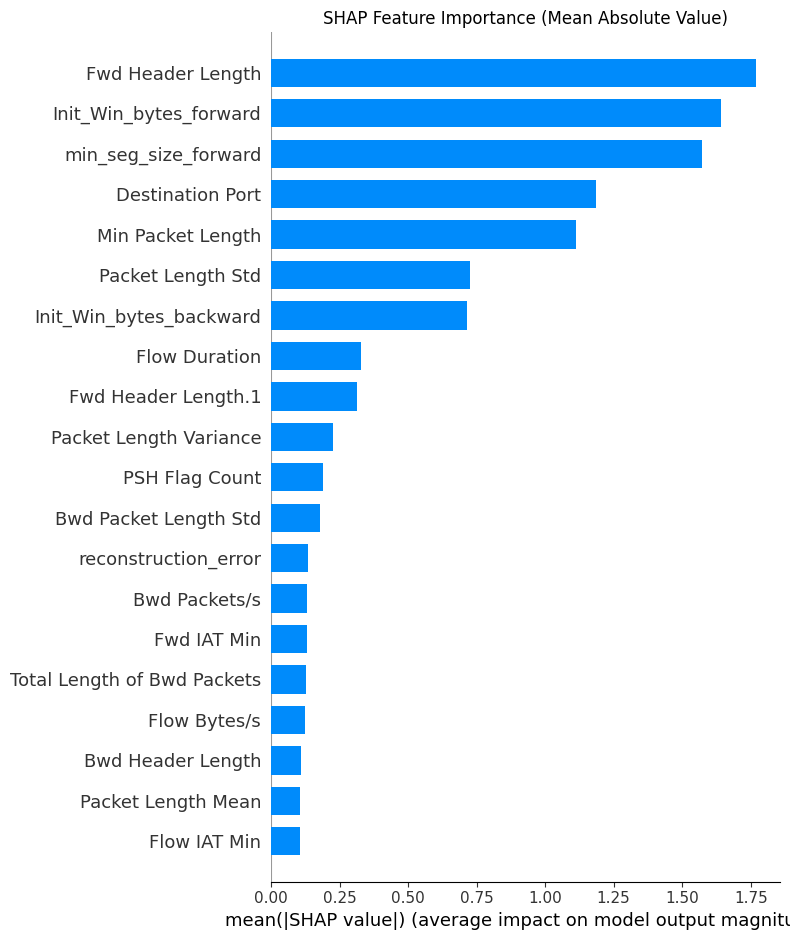

In [13]:
plt.figure(figsize=(16, 8))
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Mean Absolute Value)")
plt.tight_layout()
plt.show()


<Figure size 1800x400 with 0 Axes>

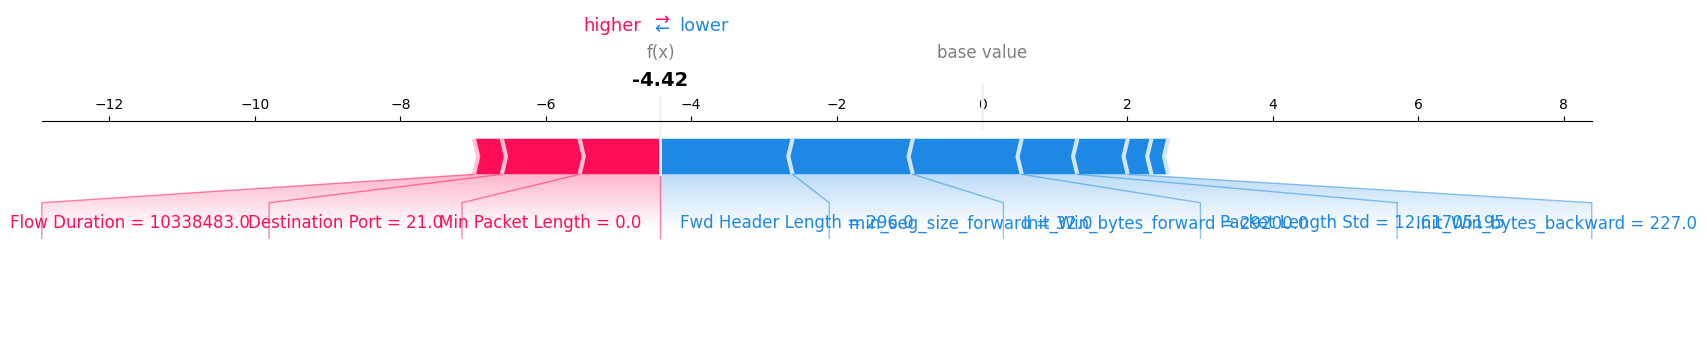

In [14]:
# pick a random attack example
idx = df[df["Label"] == 1].sample(1, random_state=42).index[0]

# get shap values
vals = shap_values[idx]
names = X.columns

# top 10 features
top_idx = np.argsort(np.abs(vals))[-10:]
top_vals = vals[top_idx]
top_feats = X.iloc[idx, top_idx]

# make clean force plot
plt.figure(figsize=(18, 4))
shap.force_plot(
    explainer.expected_value,
    top_vals,
    top_feats,
    matplotlib=True
)
plt.show()


In [19]:
import pandas as pd
import os
from pathlib import Path

# Base directory where your daily CSVs are stored
base_dir = Path(r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\data\MachineLearningCSV\MachineLearningCVE")

# Where we will save the per-attack CSVs
output_dir = base_dir / "per_attack_csvs"
output_dir.mkdir(exist_ok=True)

files = {
    "Monday": "Monday-WorkingHours.pcap_ISCX.csv",
    "Tuesday": "Tuesday-WorkingHours.pcap_ISCX.csv",
    "Wednesday": "Wednesday-workingHours.pcap_ISCX.csv",
    "Thursday_Morning": "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    "Thursday_Afternoon": "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    "Friday_Morning": "Friday-WorkingHours-Morning.pcap_ISCX.csv",
    "Friday_Afternoon": "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
    "Friday_Afternoon2": "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"
}

print("Extracting attack types...")

for day, filename in files.items():
    df = pd.read_csv(base_dir / filename)

    # Clean column names
    df.columns = [c.strip() for c in df.columns]

    # List attack strings (anything not "BENIGN")
    attack_rows = df[df["Label"] != "BENIGN"]
    attack_types = attack_rows["Label"].unique()

    print(f"\n{day}: found {len(attack_types)} attack types:")
    for attack in attack_types:
        print(" -", attack)

        # Extract rows of just this attack type
        attack_df = df[df["Label"] == attack].copy()

        # Save per attack CSV
        out_path = output_dir / f"{attack.replace('/', '_').replace(' ', '_')}.csv"
        attack_df.to_csv(out_path, index=False)

print("\nAll per-attack CSVs saved to:")
print(output_dir)


Extracting attack types...

Monday: found 0 attack types:

Tuesday: found 2 attack types:
 - FTP-Patator
 - SSH-Patator

Wednesday: found 5 attack types:
 - DoS slowloris
 - DoS Slowhttptest
 - DoS Hulk
 - DoS GoldenEye
 - Heartbleed

Thursday_Morning: found 3 attack types:
 - Web Attack � Brute Force
 - Web Attack � XSS
 - Web Attack � Sql Injection

Thursday_Afternoon: found 1 attack types:
 - Infiltration

Friday_Morning: found 1 attack types:
 - Bot

Friday_Afternoon: found 1 attack types:
 - DDoS

Friday_Afternoon2: found 1 attack types:
 - PortScan

All per-attack CSVs saved to:
C:\Users\cmhub\Desktop\network-anomaly-detector-starter\data\MachineLearningCSV\MachineLearningCVE\per_attack_csvs


Day 10 explainability notebook loaded.
Models and scalers loaded.
Hybrid model expects 79 features.
Autoencoder input features: 78
Hybrid dataset loaded: (2604998, 80)
Final X shape for hybrid model: (2604998, 79)

Computing global SHAP values...


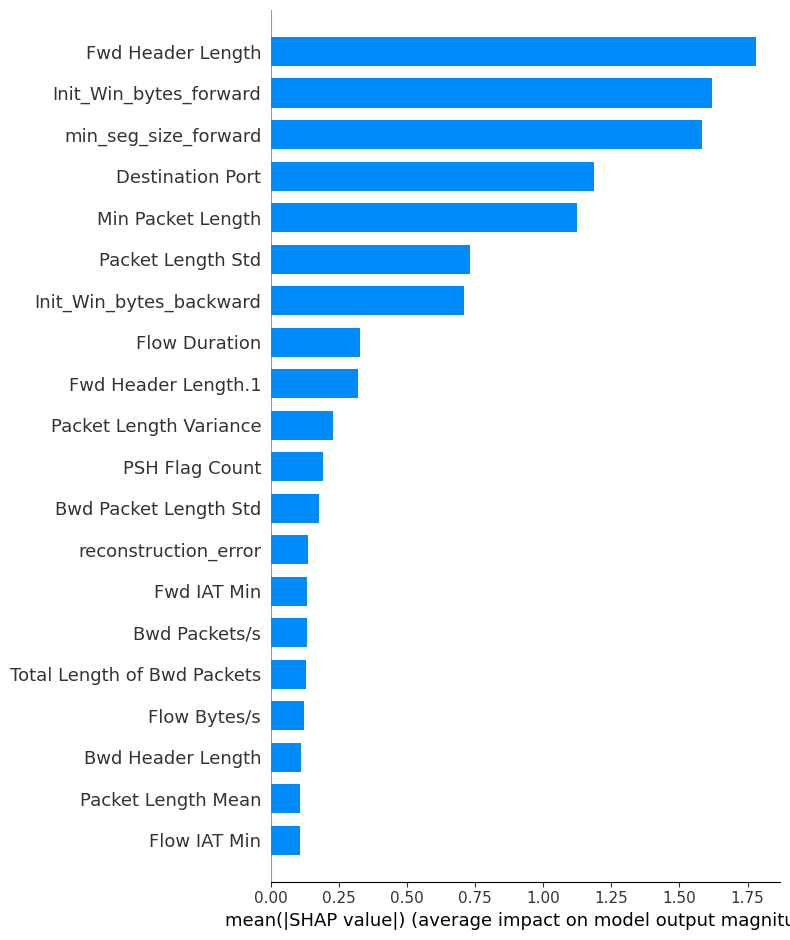


Computing local SHAP explanation for a single attack sample...


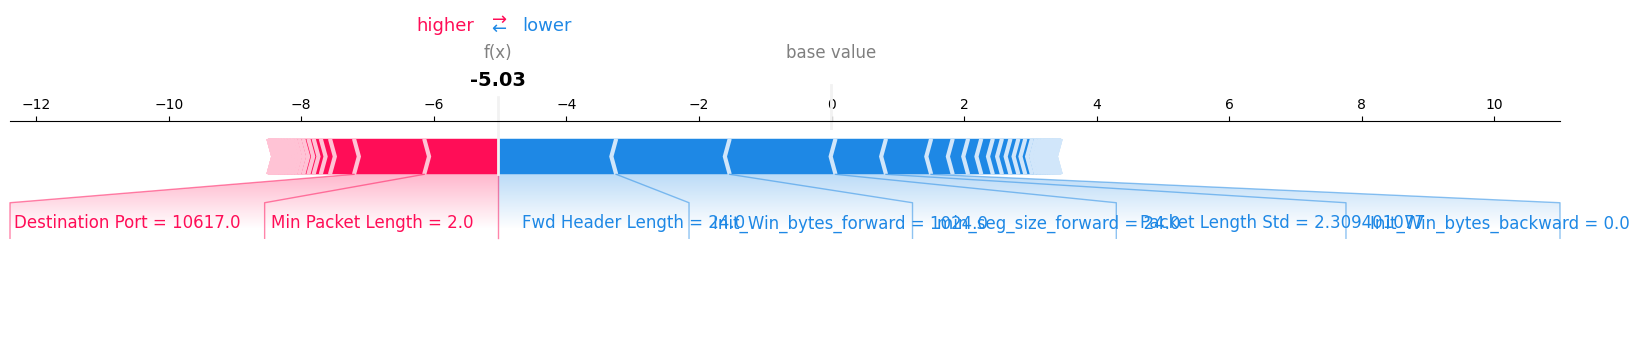


Starting per-attack-type SHAP analysis...
Found 14 per-attack CSV files.
→ Processing Bot
→ Processing DDoS
→ Processing DoS_GoldenEye
→ Processing DoS_Hulk
→ Processing DoS_Slowhttptest
→ Processing DoS_slowloris
→ Processing FTP-Patator
→ Processing Heartbleed
→ Processing Infiltration
→ Processing PortScan
→ Processing SSH-Patator
→ Processing Web_Attack_�_Brute_Force
→ Processing Web_Attack_�_Sql_Injection
→ Processing Web_Attack_�_XSS


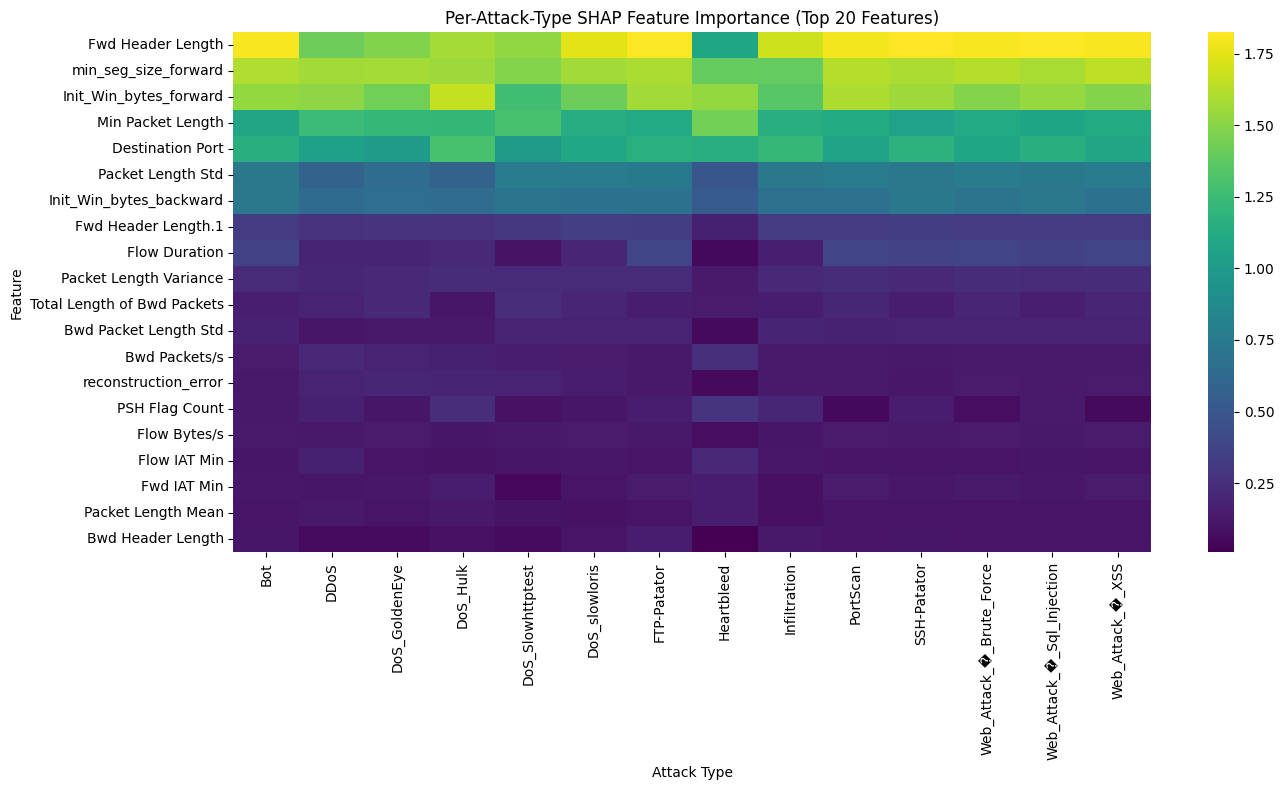


Per-attack SHAP analysis complete.


In [27]:
# ============================================================
# DAY 10 — MODEL EXPLAINABILITY (FINAL PATCHED VERSION)
# Global SHAP • Local SHAP • Per-Attack SHAP
# Uses autoencoder + hybrid XGBoost with correct feature alignment
# ============================================================

import numpy as np
import pandas as pd
import shap
import joblib
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.models import load_model

print("Day 10 explainability notebook loaded.")


# ============================================================
# Helper: cleaning function for all dataframes
# ============================================================

def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    """Replace infs, handle NaNs, clip extreme values."""
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(df.median(numeric_only=True))
    df = df.clip(lower=-1e15, upper=1e15)
    return df


# ============================================================
# 1. Load models and scalers
# ============================================================

auto_path = r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\models\autoencoder_model.keras"
auto_scaler_path = r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\models\autoencoder_scaler.pkl"
xgb_model_path = r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\models\xgboost_hybrid_model.json"
hybrid_scaler_path = r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\models\xgboost_hybrid_scaler.pkl"

autoencoder = load_model(auto_path)
auto_scaler = joblib.load(auto_scaler_path)

xgb_hybrid = xgb.XGBClassifier()
xgb_hybrid.load_model(xgb_model_path)

scaler_hybrid = joblib.load(hybrid_scaler_path)

print("Models and scalers loaded.")

# This is the exact set of features the hybrid model was trained on
required_features = list(scaler_hybrid.feature_names_in_)
print(f"Hybrid model expects {len(required_features)} features.")
assert "reconstruction_error" in required_features, "reconstruction_error must be part of required_features"


# For autoencoder, we use all features *except* reconstruction_error
auto_features = [f for f in required_features if f != "reconstruction_error"]
print(f"Autoencoder input features: {len(auto_features)}")


# ============================================================
# 2. Load the hybrid-ready dataset and recompute reconstruction_error
# ============================================================

data_path = r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\data\MachineLearningCSV\MachineLearningCVE\CICIDS2017_hybrid_ready.csv"
df = pd.read_csv(data_path)
print("Hybrid dataset loaded:", df.shape)

df = clean_df(df)

# Ensure all auto_features exist
missing_auto = [c for c in auto_features if c not in df.columns]
if missing_auto:
    raise ValueError(f"Missing expected autoencoder features in df: {missing_auto}")

X_auto = df[auto_features].copy()
X_auto_scaled = auto_scaler.transform(X_auto)

X_recon = autoencoder.predict(X_auto_scaled, verbose=0)
recon_error = np.mean((X_auto_scaled - X_recon) ** 2, axis=1)

df["reconstruction_error"] = recon_error

# Build final X for XGBoost with exact training columns
missing_required = [c for c in required_features if c not in df.columns]
if missing_required:
    raise ValueError(f"Missing expected hybrid features in df: {missing_required}")

X = df[required_features].copy()
y = df["Label"].values

X_scaled = scaler_hybrid.transform(X)
print("Final X shape for hybrid model:", X_scaled.shape)


# ============================================================
# 3. Global SHAP: which features matter most overall?
# ============================================================

print("\nComputing global SHAP values...")

# For speed, sample a subset if dataset is huge
max_samples = 5000
if X_scaled.shape[0] > max_samples:
    sample_idx = np.random.RandomState(42).choice(X_scaled.shape[0], size=max_samples, replace=False)
    X_sample = X_scaled[sample_idx]
    X_display = X.iloc[sample_idx]
else:
    X_sample = X_scaled
    X_display = X

explainer = shap.TreeExplainer(xgb_hybrid)
shap_values = explainer.shap_values(X_sample)

# Bar plot of global importance
shap.summary_plot(shap_values, X_display, plot_type="bar", max_display=20)


# ============================================================
# 4. Local SHAP: explain one attack prediction
# ============================================================

print("\nComputing local SHAP explanation for a single attack sample...")

attack_indices = np.where(y == 1)[0]
if len(attack_indices) > 0:
    idx = int(attack_indices[0])
    shap.force_plot(
        explainer.expected_value,
        shap_values[idx % len(X_sample)],
        X_display.iloc[idx % len(X_sample)],
        matplotlib=True
    )
else:
    print("No attack samples found in this dataset for local SHAP demo.")


# ============================================================
# 5. Per-attack-type SHAP analysis
# ============================================================

print("\nStarting per-attack-type SHAP analysis...")

per_attack_dir = Path(
    r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\data\MachineLearningCSV\MachineLearningCVE\per_attack_csvs"
)
attack_files = list(per_attack_dir.glob("*.csv"))
print(f"Found {len(attack_files)} per-attack CSV files.")

attack_feature_importance = {}

for attack_csv in attack_files:
    attack_name = attack_csv.stem
    print(f"→ Processing {attack_name}")

    df_attack_raw = pd.read_csv(attack_csv)

    # Keep only columns that intersect with auto_features or required_features
    # to avoid weird extra columns.
    df_attack = df_attack_raw.copy()

    # Clean and restrict to numeric
    df_attack = df_attack.select_dtypes(include=[np.number])
    df_attack = clean_df(df_attack)

    # Check auto_features exist
    missing_auto_attack = [c for c in auto_features if c not in df_attack.columns]
    if missing_auto_attack:
        print(f"  Skipping {attack_name}: missing autoencoder features {missing_auto_attack}")
        continue

    # Recompute reconstruction error for this attack subset
    X_attack_auto = df_attack[auto_features].copy()
    X_attack_auto_scaled = auto_scaler.transform(X_attack_auto)
    X_attack_recon = autoencoder.predict(X_attack_auto_scaled, verbose=0)
    attack_recon_error = np.mean((X_attack_auto_scaled - X_attack_recon) ** 2, axis=1)

    df_attack["reconstruction_error"] = attack_recon_error

    # Now build the final hybrid input
    missing_required_attack = [c for c in required_features if c not in df_attack.columns]
    if missing_required_attack:
        print(f"  Skipping {attack_name}: missing hybrid features {missing_required_attack}")
        continue

    X_attack = df_attack[required_features].copy()
    X_attack_scaled = scaler_hybrid.transform(X_attack)

    # Compute SHAP values
    svals = explainer.shap_values(X_attack_scaled)
    mean_abs = np.mean(np.abs(svals), axis=0)

    attack_feature_importance[attack_name] = mean_abs


# ============================================================
# 6. Heatmap of top 20 features per attack type
# ============================================================

if not attack_feature_importance:
    print("No valid per-attack SHAP results to plot.")
else:
    importance_df = pd.DataFrame(attack_feature_importance, index=required_features)

    TOP_N = 20
    top_features = (
        importance_df.mean(axis=1)
        .sort_values(ascending=False)
        .head(TOP_N)
        .index
    )

    importance_df_top = importance_df.loc[top_features]

    plt.figure(figsize=(14, 8))
    sns.heatmap(importance_df_top, cmap="viridis", annot=False)
    plt.title("Per-Attack-Type SHAP Feature Importance (Top 20 Features)")
    plt.xlabel("Attack Type")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    print("\nPer-attack SHAP analysis complete.")


In [26]:
print("Scaler expects:", len(scaler_hybrid.feature_names_in_))
print(scaler_hybrid.feature_names_in_)

print("XGB model feature count:", xgb_hybrid.get_booster().num_features())


Scaler expects: 79
['Destination Port' 'Flow Duration' 'Total Fwd Packets'
 'Total Backward Packets' 'Total Length of Fwd Packets'
 'Total Length of Bwd Packets' 'Fwd Packet Length Max'
 'Fwd Packet Length Min' 'Fwd Packet Length Mean' 'Fwd Packet Length Std'
 'Bwd Packet Length Max' 'Bwd Packet Length Min' 'Bwd Packet Length Mean'
 'Bwd Packet Length Std' 'Flow Bytes/s' 'Flow Packets/s' 'Flow IAT Mean'
 'Flow IAT Std' 'Flow IAT Max' 'Flow IAT Min' 'Fwd IAT Total'
 'Fwd IAT Mean' 'Fwd IAT Std' 'Fwd IAT Max' 'Fwd IAT Min' 'Bwd IAT Total'
 'Bwd IAT Mean' 'Bwd IAT Std' 'Bwd IAT Max' 'Bwd IAT Min' 'Fwd PSH Flags'
 'Bwd PSH Flags' 'Fwd URG Flags' 'Bwd URG Flags' 'Fwd Header Length'
 'Bwd Header Length' 'Fwd Packets/s' 'Bwd Packets/s' 'Min Packet Length'
 'Max Packet Length' 'Packet Length Mean' 'Packet Length Std'
 'Packet Length Variance' 'FIN Flag Count' 'SYN Flag Count'
 'RST Flag Count' 'PSH Flag Count' 'ACK Flag Count' 'URG Flag Count'
 'CWE Flag Count' 'ECE Flag Count' 'Down/Up Ratio'